# Train syllable prediction model (with word boundaries)

This notebook experiments with syllable prediction from phonetics only. Word boundaries are known.

In [1]:
import regex as re

import numpy as np

from scipy.ndimage import gaussian_filter1d

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [2]:
# Dataset loader
def load_dataset(name):
    df = pd.read_csv(f"{name}.tsv", header=None, na_filter=False, encoding="utf-8")
    values = df.values[:, 0]
    return values

In [3]:
# Load dataset
train_values = load_dataset("train")
validation_values = load_dataset("validation")
test_values = load_dataset("test")

In [4]:
# IPA tokenization regex
IPA_R = re.compile(r"(.\u0303?\u02d0?)*")

# Tokenization helper
def tokenize(pronunciation):
    match = IPA_R.fullmatch(pronunciation)
    return match.captures(1)

In [5]:
# IPA vocabulary
IPA = [
    "<PAD>",
    " ", "a", "b", "d", "e", "f", "i", "j",
    "k", "l", "m", "n", "o", "p", "s", "t",
    "u", "v", "w", "y", "z", "ø", "ŋ", "œ",
    "œ̃", "ɑ", "ɑ̃", "ɔ", "ɔ̃", "ə", "ɛ", "ɛ̃",
    "ɡ", "ɥ", "ɲ", "ʁ", "ʃ", "ʒ",
]
IPA_MAPPING = {p: i for i, p in enumerate(IPA)}

In [6]:
# Encode sample
def encode(value):
    phonemes = []
    labels = []
    for p in tokenize(value):
        l = 0

        # Dot after
        if p == ".":
            labels[-1] = 1
            continue

        # Liaison
        if p == "‿":
            p = " "
            l = 1

        # Append character
        phonemes.append(IPA_MAPPING[p])
        labels.append(l)

    # Pack as tensor
    phonemes = torch.tensor(phonemes, dtype=torch.uint8)
    labels = torch.tensor(labels, dtype=torch.uint8)
    return phonemes, labels

# Encode dataset
def encode_all(values):
    n = len(values)
    phonemes = np.empty(n, dtype=object)
    labels = np.empty(n, dtype=object)
    for i in range(n):
        phonemes[i], labels[i] = encode(values[i])
    return phonemes, labels

In [7]:
# Encode datasets
train_phonemes, train_labels = encode_all(train_values)
validation_phonemes, validation_labels = encode_all(validation_values)

In [8]:
# Pack multiple samples as a batch, with lengths
def pack_indices(phonemes, labels, max_length=None):
    n = len(phonemes)
    length = max(len(p) for p in phonemes)
    if max_length is not None and length > max_length:
        length = max_length
    phonemes_tensor = torch.zeros((length, n), dtype=torch.long)
    labels_tensor = torch.zeros((length, n), dtype=torch.long)
    lengths = torch.zeros(n, dtype=torch.long)
    for i in range(n):
        l = len(phonemes[i])
        l = min(l, length)
        for j in range(l):
            phonemes_tensor[j, i] = phonemes[i][j]
            labels_tensor[j, i] = labels[i][j]
        lengths[i] = l
    return phonemes_tensor, labels_tensor, lengths

In [9]:
# Define model
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.num_symbol = len(IPA)
        self.embedding_size = 16
        self.hidden_size = 32
        
        # Embed characters
        self.embedding = nn.Embedding(
            num_embeddings=self.num_symbol,
            embedding_dim=self.embedding_size,
            padding_idx=0,
        )
        
        # Use a single GRU
        self.gru = nn.GRU(
            input_size=self.embedding_size,
            hidden_size=self.hidden_size,
            num_layers=1,
            dropout=0,
            bidirectional=True,
        )
        
        # Use two separate classifiers
        self.classifier = nn.Linear(self.hidden_size * 2, 2)
    
    def _encode(self, phonemes, lengths):
        embeddings = self.embedding(phonemes)
        packed_embeddings = nn.utils.rnn.pack_padded_sequence(embeddings, lengths, enforce_sorted=False)
        packed_encodings, _ = self.gru(packed_embeddings)
        encodings, _ = nn.utils.rnn.pad_packed_sequence(packed_encodings)
        logits = self.classifier(encodings)
        return logits
    
    def forward(self, phonemes, labels, lengths):
        
        # Compute elementwise loss
        logits = self._encode(phonemes, lengths)
        l = labels.to(torch.float32)
        dot_losses = F.binary_cross_entropy_with_logits(logits[:, :, 0], l, reduction="none")
        liaison_losses = F.binary_cross_entropy_with_logits(logits[:, :, 1], l, reduction="none")
        
        # Only apply on relevant locations
        dot_mask = (phonemes[:-1] > 1) & (phonemes[1:] > 1)
        laison_mask = phonemes == 1
        
        # Compute loss
        dot_loss = torch.sum(dot_losses[:-1] * dot_mask)
        liaison_loss = torch.sum(liaison_losses * laison_mask)
        loss = dot_loss + liaison_loss
        return loss

In [10]:
# Create model
model = Model()

# Use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [11]:
indices = np.arange(len(train_phonemes))

batch_size = 32
max_length = 64

n_batches = (len(indices) - 1) // batch_size + 1

losses = []

for epoch in range(1):
    np.random.shuffle(indices)

    with tqdm(range(n_batches)) as progress:
        for batch in progress:

            optimizer.zero_grad()

            idx = indices[batch*batch_size:(batch+1)*batch_size]
            batch_phonemes, batch_labels, batch_lengths = pack_indices(train_phonemes[idx], train_labels[idx], max_length)

            loss = model(batch_phonemes, batch_labels, batch_lengths)

            loss.backward()
            optimizer.step()

            loss = float(loss.detach())
            losses.append(loss)
            progress.set_description(f"{loss:.03f}")

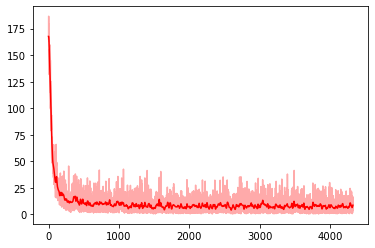

In [12]:
fig, ax = plt.subplots()

y = np.array(losses)
x = np.arange(y.shape[0])
y_smooth = gaussian_filter1d(y, 5, mode="nearest")

ax.plot(x, y, c="#ffaaaa")
ax.plot(x, y_smooth, "r")

plt.show()

In [13]:
# Save model
torch.save(model.state_dict(), "model.space.pt")

In [14]:
# Import model for inference
model = Model()
model.load_state_dict(torch.load("model.space.pt"))
model.eval()

Model(
  (embedding): Embedding(39, 16, padding_idx=0)
  (gru): GRU(16, 32, bidirectional=True)
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

## Apply model

In [15]:
def infer_syllable(pronunciation):
    
    # Encode
    phonemes, labels = encode_all([pronunciation])
    phonemes, labels, lengths = pack_indices(phonemes, labels)
    
    # Apply model
    logits = model._encode(phonemes, lengths)
    probabilities = torch.sigmoid(logits)
    
    # Compute application mask
    dot_mask = torch.zeros_like(phonemes, dtype=torch.bool)
    dot_mask[:-1] = (phonemes[:-1] > 1) & (phonemes[1:] > 1)
    laison_mask = phonemes == 1
    
    # Compute actual probabilities
    dot_probabilities = probabilities[:, :, 0] * dot_mask
    liaison_probabilities = probabilities[:, :, 1] * laison_mask
    
    # Threshold
    dot_output = dot_probabilities > 0.5
    liaison_output = liaison_probabilities > 0.5
    
    # Reconstruct pronunciation
    parts = []
    for i in range(phonemes.shape[0]):
        if phonemes[i, 0] == 1:
            if liaison_output[i, 0]:
                parts.append("‿")
            else:
                parts.append(" ")
        else:
            parts.append(IPA[phonemes[i, 0]])
            if dot_output[i, 0]:
                parts.append(".")
    syllable = "".join(parts)
    return syllable

In [16]:
# Manual example (from train set)
infer_syllable("vɛk.tœʁ a.le.a.twaʁ kɔ̃.ti.ny")

'vɛk.tœʁ‿a.le.a.twaʁ kɔ̃.ti.ny'

In [17]:
# Apply on some element of the test set
n = len(test_values)
indices = torch.randperm(n)[:10]
for i in indices:
    truth = test_values[i]
    prediction = infer_syllable(test_values[i])
    status = "OK" if truth == prediction else "NOPE"
    print(f"#{i}: {status}")
    print(f"  truth: {truth}")
    print(f"  pred.: {prediction}")

#50547: OK
  truth: mɛʁ dy syd
  pred.: mɛʁ dy syd
#38756: OK
  truth: ɔ.to.a.bɛ.sɔ̃
  pred.: ɔ.to.a.bɛ.sɔ̃
#68887: OK
  truth: po.li.mɔʁ.fism də sit də ʁɛs.tʁik.sjɔ̃
  pred.: po.li.mɔʁ.fism də sit də ʁɛs.tʁik.sjɔ̃
#52756: OK
  truth: ʁe.a.mœ.blɛ
  pred.: ʁe.a.mœ.blɛ
#27818: OK
  truth: ʁe.y.mɛkt
  pred.: ʁe.y.mɛkt
#23352: OK
  truth: pa.le.ɔ.sɛn
  pred.: pa.le.ɔ.sɛn
#14574: OK
  truth: ɑ̃.fɑ̃.sɔ.nɛ
  pred.: ɑ̃.fɑ̃.sɔ.nɛ
#45901: OK
  truth: ɡaʁ.sɔ.nje
  pred.: ɡaʁ.sɔ.nje
#60462: OK
  truth: ɔʁ.ɡa.nɔ.me.ta.lik
  pred.: ɔʁ.ɡa.nɔ.me.ta.lik
#15019: OK
  truth: sa.kaɲ
  pred.: sa.kaɲ


## Evaluate

In [18]:
# Use test set
values = test_values

In [19]:
# Pack everything
phonemes, labels = encode_all(values)
phonemes, labels, lengths = pack_indices(phonemes, labels)

In [20]:
# Apply model, using batches
probabilities = torch.zeros_like(phonemes, dtype=torch.float32)
batch_size = 32
n_batches = (len(values) - 1) // batch_size + 1
with torch.no_grad():
    for b in tqdm(range(n_batches)):
        batch_phonemes = phonemes[:, b*batch_size:(b+1)*batch_size]
        batch_labels = labels[:, b*batch_size:(b+1)*batch_size]
        batch_lengths = lengths[b*batch_size:(b+1)*batch_size]

        # Apply model
        batch_logits = model._encode(batch_phonemes, batch_lengths)
        batch_probabilities = torch.sigmoid(batch_logits)

        # Compute application mask
        dot_mask = torch.zeros_like(batch_phonemes, dtype=torch.bool)
        dot_mask[:-1] = (batch_phonemes[:-1] > 1) & (batch_phonemes[1:] > 1)
        laison_mask = batch_phonemes == 1

        # Compute actual probabilities
        l = batch_probabilities.shape[0]
        probabilities[:l, b*batch_size:(b+1)*batch_size] = (
            batch_probabilities[:, :, 0] * dot_mask[:l] +
            batch_probabilities[:, :, 1] * laison_mask[:l]
        )

In [21]:
truth = labels > 0
prediction = probabilities > 0.5
mask = phonemes > 0

tp = int((( truth &  prediction) & mask).sum())
fp = int(((~truth &  prediction) & mask).sum())
tn = int(((~truth & ~prediction) & mask).sum())
fn = int((( truth & ~prediction) & mask).sum())

accuracy = (tp + tn) / (tp + fp + tn + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"accuracy: {100*accuracy:.2f}%")
print(f"precision: {100*precision:.2f}%")
print(f"recall: {100*recall:.2f}%")

accuracy: 99.22%
precision: 98.52%
recall: 98.77%


In [22]:
# Compute character error rate
error_count = (truth != prediction).sum(axis=0)
length = mask.sum(axis=0)
character_error_rate = error_count.to(torch.float32) / length

In [23]:
def prediction_to_text(phonemes, prediction):
    characters = []
    for p, l in zip(phonemes, prediction):
        if p == 0:
            break
        if p == 1:
            if l:
                characters.append("‿")
            else:
                characters.append(" ")
        else:
            characters.append(IPA[p])
            if l:
                characters.append(".")
    syllable = "".join(characters)
    return syllable


predictions = [prediction_to_text(phonemes[:, i], prediction[:, i]) for i in range(len(values))]

In [24]:
# Pack as data frame
out_df = pd.DataFrame({
    "truth": values,
    "prediction": predictions,
    "cer": character_error_rate,
})

In [25]:
# Show all errors
with pd.option_context("display.max_rows", 9999):
    mistakes = out_df[out_df["cer"] > 0]
    display(mistakes.sort_values("cer", ascending=False))

truth  \
5406                                          ɛʁ.ə.ɛʁ.iz   
59378                                         a.j‿a.j‿aj   
57556                                             a.ɛs.ə   
4095                                               ɛl.aʃ   
57428                                             ɛ.stɛ̃   
43978                                       ɛʁ.ə.ɛʁ.i.za   
48716                                              il.ɔp   
59146                                             ɛs.ə.o   
34403                                              ɛf.ʁɛ   
73196                                             a.vnɑ̃   
52742                                     be.aʃ.ɛl.i.zɔ̃   
24150                                        a.lwɛt y.pe   
68041                                        ʒi.mnɔ.stil   
66167                                       ɛ̃.skʁi.ptœʁ   
64221                                        ʒi.mnɔ.spɔʁ   
43495                                             ʒak.ʁi   
73053                                             tɑ.sʁɛ   
47602                                             by.ksi   
51519                                            ɛ̃t.ʁiɡ   
65606                                             ɛtʁ.ɔf   
59155                                    sy.ʁɑ̃t.ʁɛn.mɑ̃   
58247                                             ɡɑt.ʁi   
25436                                             mɛ.tʃi   
39899                                             ti.kne   
3640                                             i.ɛʁ.ɛs   
45291                                      ø.dja.pnø.sti   
1830                                             pet.ʁɛ̃   
32871                                             ɡɔl.wɛ   
72957                                            mɑ.ʃʁɔ̃   
4775                                      fɑ̃.tasm.at.ik   
7533                                              i.vlin   
1777                                              pɛt.ʁɔ   
38148                                            o.ɛm.ɛs   
69116                                            dik.jɛ̃   
50334                                            ʁoz.ʁɛ̃   
19420                                            ɛl.i.de   
63833                                            fɔʁ.y.a   
35210                                            se.ɛl.ə   
17140                                      a.vwa.ʁ‿a.ksɛ   
46986                                             si.vlɔ   
20223                                             pik.ʁi   
73190                                             ta.ʃte   
10826                                             eʃ.lɔn   
72923                                             ʃɔ.mʁe   
62500                                             nyl.aʃ   
52522                                            vɑ̃t.ʁe   
42900                                             van.of   
46670                                             ku.ʁta   
72994                                             ɔ.pnɛz   
33039                                             ɔ.skan   
57687                                             bɔ.sko   
58949                                            fɔʁ.y.e   
25536                                             ʁab.za   
73111                                          silts.ajm   
35696                                     vɛʁ ɛk.spɑ̃.se   
37521                                   be.aʃ.ɛl.i.zə.ʁa   
33508                                     a.ɡnɔ.sti.sism   
73328                                      mɛtʁ.ə vɛʁ.je   
59288                                     ɛ.li.psɔ.spɛʁm   
14949                                           wɛb.i.ze   
71070                                            lajn.œp   
34770                                            fy.stin   
35350                                         ɛ̃t.ʁi.ɡɑ̃   
70767                                    ʃe.ma iks.ɛm.ɛl   
10694                                           blɛt.ʁɑ̃   
23689                                           suz.e.mi   
25137                          

In [26]:
# Export TSV
out_df.to_csv("output.space.tsv", sep="\t", index=False, encoding="utf-8")